G:\Programmes\miniconca3\lib\site-packages\ipykernel_launcher.py:282: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
G:\Programmes\miniconca3\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]


[[16203     0     0]
 [16704     0     0]
 [16704     0     0]]
Normalized confusion matrix


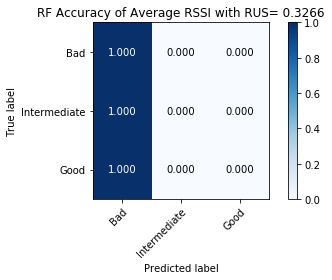

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.api as smg
import matplotlib.dates as md
import xgboost
from sklearn import datasets, linear_model, svm
from statsmodels.formula.api import ols
from patsy.highlevel import dmatrices
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from scipy.stats import spearmanr
from pylab import rcParams
import seaborn as sb
from sklearn import metrics
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic

from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
pd.options.display.max_rows=10
from datetime import datetime
import numpy as np
df = pd.read_table("grenoble_7.k7",sep = ',',header = 0)

class_names=['Bad','Intermediate','Good']
classifier=svm.SVC(kernel='linear',C=0.01)

correlations = df['mean_rssi'][0:].astype('float64').corr(df['pdr'][0:].astype('float64'))
#print(correlations)

#plt.matshow(df.corr())
#plt.show()

def val_prediction_pdr(df):
    ret=list()
    for i in range(len(df)):
        if df['pdr'][i] < 0.02:
            ret.append(0.5)
        elif df['pdr'][i] >= 0.02 and df['pdr'][i] < 0.25:
            ret.append(df['pdr'][i])
        elif df['pdr'][i] >= 0.25 and df['pdr'][i] < 0.3:
            ret.append(0.9)
        elif df['pdr'][i] >= 0.3 and df['pdr'][i] <= 0.35:
            ret.append(0.1)
        elif df['pdr'][i] > 0.35 and df['pdr'][i] <= 0.73:
            ret.append(df['pdr'][i])
        elif df['pdr'][i] >= 0.73 and df['pdr'][i] <= 0.75:
            ret.append(0.9)
        elif df['pdr'][i] > 0.75 and df['pdr'][i] <= 0.8:
            ret.append(0.1)
        elif df['pdr'][i] > 0.8 and df['pdr'][i] < 0.85:
            ret.append(0.5)
        else:
            ret.append(df['pdr'][i])
    #print(ret)
    return ret

def val_prediction_rssi(df):
    ret=list()
    for i in range(len(df)):
        if df['mean_rssi'][i] < -89:
            ret.append(-50)
        elif df['mean_rssi'][i] >= -89 and df['mean_rssi'][i] <= -75:
            ret.append(df['mean_rssi'][i])
        elif df['mean_rssi'][i] > -75 and df['mean_rssi'][i] < -70:
            ret.append(-30)
        elif df['mean_rssi'][i] >= -70 and df['mean_rssi'][i] < -69:
            ret.append(-75)
        elif df['mean_rssi'][i] >= -69 and df['mean_rssi'][i] <= -42:
             ret.append(df['mean_rssi'][i])
        elif df['mean_rssi'][i] > -42 and df['mean_rssi'][i] <= -40:
             ret.append(-30)
        elif df['mean_rssi'][i] > -40 and df['mean_rssi'][i] <= -35:
             ret.append(-75)
        elif df['mean_rssi'][i] >=-30 and df['mean_rssi'][i] <= -26:
             ret.append(df['mean_rssi'][i])
        else:
            ret.append(-50)
    return ret

def trace_conf_mat(cm, acc,classes, norm, title,cmap=plt.cm.Blues):
    accuracy=acc
    print(cm)
    classes = ['Bad','Intermediate','Good']
    if norm:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title+'%.4f' % accuracy,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if norm else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
    
    

def plot_confusion_matrix_rssi(df, classes, normalize=False, title=None,cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Accuracy of Average RSSI= '
        else:
            title = 'Accuracy of Average RSSI='
    y_true=list()
    y_pred=list()
    val_pred=val_prediction_rssi(df)
    for i in range(len(df)):
        if df['mean_rssi'][i] < -70:
            y_true.append('Bad')
        elif df['mean_rssi'][i] > -40:
            y_true.append('Good')
        else:
            y_true.append('Intermediate')
        
        if val_pred[i] < -70:
            y_pred.append('Bad')
        elif val_pred[i] > -40:
            y_pred.append('Good')
        else:
            y_pred.append('Intermediate')
    cm=confusion_matrix(y_true,y_pred)
    t=cm[0][0]+cm[1][1]+cm[2][2]
    accuracy=t/len(df)
    trace_conf_mat(cm, accuracy,classes, normalize, title,cmap=plt.cm.Blues)
np.set_printoptions(precision=2)

def linear_SVM_rssi(df, classes, normalize=False, title=None,cmap=plt.cm.Blues):
    ros = RandomOverSampler(random_state=0)
    rus = RandomUnderSampler(random_state=0)
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    y_true=list()
    y_pred=list()
    target=list()
    for i in range(len(df)):
        if df['mean_rssi'][i] < -70:
            target.append(0)
        elif df['mean_rssi'][i] > -40:
            target.append(2)
        else:
            target.append(1)
        if val_pred[i] < -70:
            y_pred.append(0)
        elif val_pred[i] > -40:
            y_pred.append(2)
        else:
            y_pred.append(1)
    df['target']=target
    df['pred']=y_pred
    
    mydata=df.ix[:,(5,7)].values#Column 5 corresponds to the value of PDR and column 7 to the value representing that valu in class(BadnGood and Intermediate)
    X=scale(mydata)
    y=df['pred']
         
            
    X_resampled, y_resampled = ros.fit_resample(X, y)
    
    clf = LinearSVC(random_state=0, tol=1e-5)
    clf.fit(X_resampled, y_resampled)
    
    y_test=y_resampled
    y_pred = clf.predict(X_resampled)
    print('y_test',y_test)
    print('y_pred',y_pred)
    #print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    #Plotting of Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    accuracy=clf.score(X_resampled,y_pred)
    
    trace_conf_mat(cm, accuracy,classes, normalize, title,cmap=plt.cm.Blues)
np.set_printoptions(precision=2)  


def logistic_regression_rssi(df, classes, normalize=False, title=None,cmap=plt.cm.Blues):
    ros = RandomOverSampler(random_state=0)
    rus = RandomUnderSampler(random_state=0)
    y_true=list()
    y_pred=list()
    target=list()
    val_pred=val_prediction_rssi(df)
    for i in range(len(df)):
        if df['mean_rssi'][i] < -70:
            target.append(0)
        elif df['mean_rssi'][i] > -40:
            target.append(2)
        else:
            target.append(1)
        if val_pred[i] < -70:
            y_pred.append(0)
        elif val_pred[i] > -40:
            y_pred.append(2)
        else:
            y_pred.append(1)
    df['target']=target
    df['pred']=y_pred
    mydata=df.ix[:,(4,7)].values#Column 4 corresponds to the value of mean_rssi and column 7 to the value representing that valu in class(BadnGood and Intermediate)
    #X=scale(mydata)
    X= mydata
    y=df.pred
    X_resampled, y_resampled = rus.fit_resample(X, y)
   
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.5, random_state=0, shuffle=False)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=None,shuffle=False)
    logreg = LogisticRegression()
    logreg=logreg.fit(X_train, y_train)
    
    y_pred = logreg.predict(X_test)
    
    #print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    #Plotting of Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    
    #accuracy=(cm[0][0]+cm[1][1]+cm[2][2])/(cm[0][0]+cm[0][1]+cm[0][2]+cm[1][0]+cm[1][1]+cm[1][2]+cm[2][0]+cm[2][1]+cm[2][2])
    accuracy=logreg.score(X_test,y_test)
    trace_conf_mat(cm, accuracy,classes, normalize, title,cmap=plt.cm.Blues)
    
np.set_printoptions(precision=2)

def random_forest_rssi(df, classes, normalize=False, title=None,cmap=plt.cm.Blues):
    ros = RandomOverSampler(random_state=0)
    rus = RandomUnderSampler(random_state=0)
    y_true=list()
    y_pred=list()
    target=list()
    val_pred=val_prediction_rssi(df)
    for i in range(len(df)):
        if df['mean_rssi'][i] < -70:
            target.append(0)
        elif df['mean_rssi'][i] > -40:
            target.append(2)
        else:
            target.append(1)
        
        if val_pred[i] < -70:
            y_pred.append(0)
        elif val_pred[i] > -40:
            y_pred.append(2)
        else:
            y_pred.append(1)
    df['target']=target
    df['pred']=y_pred
    mydata=df.ix[:,(4,7)].values#Column 4 corresponds to the value of mean_rssi and column 7 to the value representing that valu in class(BadnGood and Intermediate)
    #X=scale(mydata)
    X= mydata
    y=df.pred
    X_resampled, y_resampled = rus.fit_resample(X, y)
    
    clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.99, random_state=0,shuffle=False)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0,shuffle=False)
    CLF = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
    CLF.fit(X_train, y_train)
    
    y_pred = CLF.predict(X_test)
    
    #print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    #Plotting of Confusion Matrix
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_test, y_pred)
    
    #accuracy=(cm[0][0]+cm[1][1]+cm[2][2])/(cm[0][0]+cm[0][1]+cm[0][2]+cm[1][0]+cm[1][1]+cm[1][2]+cm[2][0]+cm[2][1]+cm[2][2])
    accuracy=CLF.score(X_test, y_test)
    
    trace_conf_mat(cm, accuracy,classes, normalize, title,cmap=plt.cm.Blues)
np.set_printoptions(precision=2)

def trace_confusion_matrix(path):
    
    #plot_confusion_matrix_rssi(df, classes=class_names, title='Accuracy of Average RSSI= ')
    #plt.savefig("rssi\ConfusionMatrixWithoutNormalizationRSSI.png", format='png', bbox_inches='tight', pad_inches=0)
    
    #plot_confusion_matrix_rssi(df, classes=class_names, normalize=True,title='Accuracy of Average RSSI= ')
    #plt.savefig("rssi\\NormalizedConfusionMatrixRSSI.png",format='png',bbox_inches='tight',pad_inches=0)
    
    
    #logistic_regression_rssi(df, classes=class_names, title='LR Accuracy of Average RSSI= ') 
    #plt.savefig("rssi\LRConfusionMatrixWithoutNormalization.png", format='png', bbox_inches='tight', pad_inches=0)
    
    #logistic_regression_rssi(df, classes=class_names, normalize=True,title='LR Accuracy of Average RSSI with RUS= ')
    #plt.savefig("rssi\LR_CM_With RUS.png", format='png', bbox_inches='tight', pad_inches=0)
    
    #linear_SVM_rssi(df, classes=class_names, title='SVM Accuracy of Average RSSI= ') 
    #plt.savefig("rssi\SVMConfusionMatrixWithoutNormalizationRSSI.png", format='png', bbox_inches='tight', pad_inches=0)
    
    #linear_SVM_rssi(df, classes=class_names, normalize=True,title='SVM Accuracy of Average RSSI= ')
    #plt.savefig("rssi\SVMConfusionMatrixWithoutNormalizationRSSI.png", format='png', bbox_inches='tight', pad_inches=0)
    
    random_forest_rssi(df, classes=class_names, normalize=True,title='RF Accuracy of Average RSSI with RUS= ')
    plt.savefig(path+"\\RF_CM_With RUS.png", format='png', bbox_inches='tight', pad_inches=0)
    
path="C:\\Users\Hp\\Documents\\TEST\\FINAL\\GENERAL\\"
trace_confusion_matrix(path)

